⚠️ **提示一下哈：**  

    1、运行没问题，如果有问题，请找我 请找我 请找我... x10086（我会态度很好地改正的！  
    2、手写数字识别分为三大块：数据探索、搭建神经网络（基础作业部分）、优化神经网络（进阶作业部分）  
    3、出于个人偏好，我把作业合一块儿写了，谢谢批改🙏！

# 初探Mnist手写数字识别

MNIST 数据集来自美国国家标准与技术研究所（NIST，National Institute of Standards and Technology）。其训练集，是由来自 250 个不同人手写的数字构成，其中 50% 是高中学生，50% 来自人口普查局（the Census Bureau）的工作人员，而测试集也是同样比例的手写数字数据。

每张手写数字图片都是 28x28 大小，为黑白浮点数构成。这不同于传统意义上的png/jpg格式图片，因为png或者jpg的图片格式，会带有很多干扰信息，如数据块、图片头尾、长度，这些图片不利于被处理成很简易的二维数组。所以，以MNIST数据集入门，使用Tensorflow来实现一个简单的手写数字识别网络，可采用dropout、learingratedecay、初始化等方式优化网络，使得其最终在validation数据上的得分能尽可能的提高。  


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
%matplotlib inline

tf.logging.set_verbosity(tf.logging.INFO)

## 一、数据探索

MNIST 数据集可在 http://yann.lecun.com/exdb/mnist/ 获取，它包含了四个部分：  

**Training set images：**  train-images-idx3-ubyte.gz   (9.9 MB, 解压后 47 MB, 包含 60,000 个样本)  
**Training set labels：**    train-labels-idx1-ubyte.gz     (29 KB, 解压后 60 KB, 包含 60,000 个标签)  
**Test set images：**       t10k-images-idx3-ubyte.gz    (1.6 MB, 解压后 7.8 MB, 包含 10,000 个样本)  
**Test set labels：**         t10k-labels-idx1-ubyte.gz      (5KB, 解压后 10 KB, 包含 10,000 个标签)  

### 1、导入数据


In [2]:
# 下载数据后解压，返回含有train, validation, test的Datasets
mnist = input_data.read_data_sets("./MNIST_data/")

print(mnist.train.images.shape)
print(mnist.train.labels.shape)

print(mnist.validation.images.shape)
print(mnist.validation.labels.shape)

print(mnist.test.images.shape)
print(mnist.test.labels.shape)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)
(55000,)
(5000, 784)
(5000,)
(10000, 784)
(10000,)


### 2、查看数据

由于images里面的每张图片，是一个784长度的一维向量，所以输出时需要把它还原成28x28的二维图片。

#### （1）查看train训练集中数据

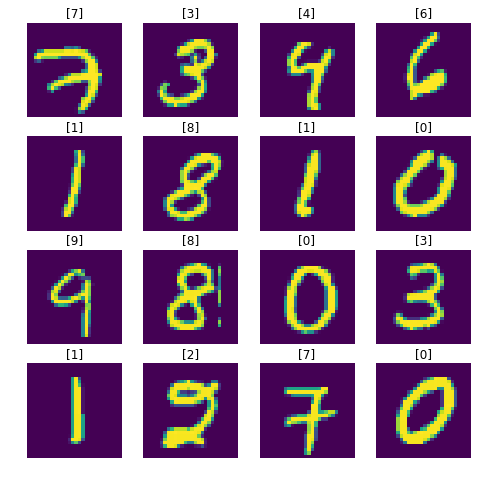

In [3]:
plt.figure(figsize=(8,8))

for idx in range(16):
    plt.subplot(4,4, idx+1)
    plt.axis('off')
    plt.title('[{}]'.format(mnist.train.labels[idx]))
    plt.imshow(mnist.train.images[idx].reshape((28,28)))


💬 **理解：**  明显，训练集数据是随机排列的，所以接下来要把需要的数据找出来。

#### （2）查看0-9手写数字

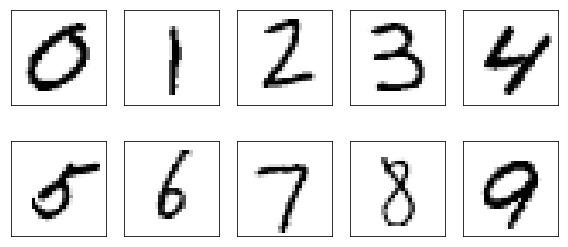

In [4]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True,
    figsize=(8, 4))
ax = ax.flatten()

for i in range(10):
    for j in range(90,500):  # 在train中搜索第90到500个数据之间的0-9
        if mnist.train.labels[j] == i: 
            img = mnist.train.images[j].reshape(28, 28)
            ax[i].imshow(img, cmap='Greys', interpolation='nearest')
            break
            
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


#### （3）查看单个数字的不同形态

同一个数字的写法可能有多种，其形态各异，于是打印出来，感受一下数据。

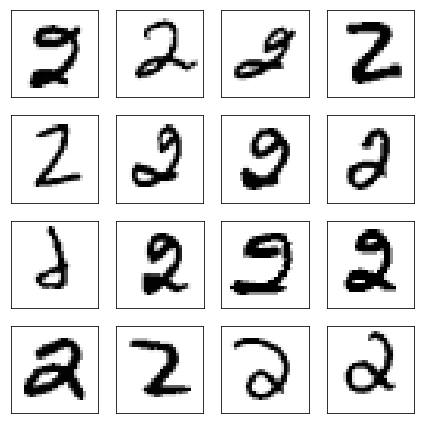

In [5]:
fig, ax = plt.subplots(
    nrows = 4,
    ncols = 4,
    sharex = True,
    sharey = True,
    figsize = (6, 6))
ax = ax.flatten()
count = 0;

for i in range(250):  # 在train中搜索前250个数据
    if mnist.train.labels[i] == 2: 
        img = mnist.train.images[i].reshape(28, 28)
        ax[count].imshow(img, cmap='Greys', interpolation='nearest')
        count += 1;
        if count == 16 : 
            break
            
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


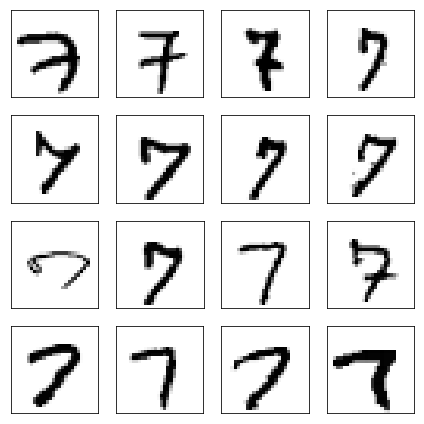

In [6]:
fig, ax = plt.subplots(
    nrows = 4,
    ncols = 4,
    sharex = True,
    sharey = True,
    figsize = (6, 6))
ax = ax.flatten()
count = 0;

for i in range(250):  # 在train中搜索前250个数据
    if mnist.train.labels[i] == 7: 
        img = mnist.train.images[i].reshape(28, 28)
        ax[count].imshow(img, cmap='Greys', interpolation='nearest')
        count += 1;
        if count == 16 : 
            break
            
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


#### （4）查看手写数字二维矩阵

In [7]:
# 为了显示好看，故截取精度
np.set_printoptions(precision=2, linewidth=256)
print(mnist.train.images[10].reshape(28, 28))

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.35 0.84 1.   1.   1.   1.   0.84 0.11 0.02 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.43 0.99 0.99 0.98 0.95 0.96 0.99 0.99 0.99 0.82 0.09 0.   0.   0.   0.   0.   0.   0.  ]

In [8]:
mnist.train.labels

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

💬 **理解：**  本来，对于uint8型的图像数据，数值范围为是 0-255 ，其中0是背景白色，255是前景黑色。但是，照这个输出结果，看来数据是做过归一化了，而且正好是范围在 0-1 之间的float32型，方便显示图像，很好。不过，标签label还是0-9这几个数字呢，那么之后如果输出层要用Softmax计算交叉熵作为损失函数的话，那是不是要做独热编码了。


## 二、搭建神经网络

### 1、定义神经网络模型

#### （1）计算图

模型训练：**batch_size：**32、**trainig_step：**1000、**learning_rate：**0.3  

第一层：输入层、**x：**0-1（白-黑）、**y：**0-9（未独热编码）  
第二层：隐层（100个节点）、**W/b：**方差为0.1的正态分布、ReLU激活  
第三层：输出层（10个节点）、**W/b：**依然是正态分布sigma为0.1、输出未激活  

In [9]:
# 占位：图像、label、学习率，等待运行时传参
x = tf.placeholder("float", [None, 784])  # 第一个维度为batchsize，设立None值留空
y = tf.placeholder("int64", [None])
learning_rate = tf.placeholder("float")

# 归一化：正态分布，均值和标准差自己设定
def initialize(shape, stddev=0.1):
    return tf.truncated_normal(shape, stddev=0.1)


# 隐层：100个神经元
L1_units_count = 100
W_1 = tf.Variable(initialize([784, L1_units_count]))
b_1 = tf.Variable(initialize([L1_units_count]))

logits_1 = tf.matmul(x, W_1) + b_1
output_1 = tf.nn.relu(logits_1)  # 这里用的ReLU激活函数


# 输出层：10个神经元
L2_units_count = 10 
W_2 = tf.Variable(initialize([L1_units_count, L2_units_count]))
b_2 = tf.Variable(initialize([L2_units_count]))

logits_2 = tf.matmul(output_1, W_2) + b_2  
logits = logits_2


Instructions for updating:
Colocations handled automatically by placer.


#### （2）损失函数与优化器

**loss损失函数：**  

    对于分类问题，采用交叉熵损失cross_entropy_loss，使用了sparse_softmax_cross_entropy_with_logits方法，这样做的好处是labels可以不用手动做one_hot编码，在求取下标时省了一些麻烦。而且，由于tensorflow把softmax计算与cross entropy计算放到一起来用函数实现，这提高了程序的运行速度。（呐，官方文档是这么说的，我反正还是觉得这种写法很另类  

**optimizer优化器：**  

    在反向传播中，采用了随机梯度下降SGD优化器，其中，学习率为可以根据需要设定。而且，此操作每运行一次，神经网络就完成一趟前向传播+反向传播，根据batch批次来的。


In [10]:
# 如果label为one-hot格式，则可以使用
# tf.nn.softmax_cross_entropy_with_logits()

cross_entropy_loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(cross_entropy_loss)


#### （3）评估性能

    使用正确率评价指标，将输出结果与正确结果进行对比，即可得到此神经网络输出结果的准确率。其中，需要注意的是，由于输出层的logits，是未经softmax函数激活的。所以，输出的数值不是概率分布，若要想看到概率分布，还是需要做一下softmax。


In [11]:
pred = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(pred, 1), y)  # axis: 0为列, 1为行，其中按行/列计算最大值后，输出最大值的下标
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))  # 对batch_size里的每个样本统计求正确率，把样本预测值boolean强制类型转换成float


#### （4）保存模型

    训练完模型之后，可用Saver去保存或恢复训练模型的相关结果，特别是中间过程的训练参数，以便下次迭代的训练或者是测试使用。其中，Saver类提供了向checkpoints文件保存，和从checkpoints文件中恢复变量的相关方法。Checkpoints文件是一个二进制文件，它能把变量名映射到对应的tensor值中。只要提供一个计数器，当计数器触发时，Saver类可以自动的生成checkpoint文件，使得在训练过程中可以随时保存多个中间结果。
    

In [12]:
batch_size = 32
trainig_step = 1000

saver = tf.train.Saver()

### 2、运行模型

    以上定义的所有操作，均为计算图，也就是仅仅定义了神经网络的结构。若要运行计算图的话，还需要创建一个session对象，将数据填入到网络中。因为，Session提供了Operation执行和Tensor求值的环境。
    
    首先，saver.save函数将TensorFlow模型保存为.ckpt的后缀文件中。又由于，TensorFlow会将计算图的结构和图上参数取值分开保存，所以保存会出现3个文件checkpoint、model.ckpt.meta、model.ckpt。
    
    （1）checkpoint文件：保存了一个目录下所有的模型文件列表，由tf.train.Saver类自动生成且自动维护的。
    （2）model.ckpt.meta文件：保存了计算图的结构，也就是元图数据 (MetaGraph) 。其记录了计算图中节点的信息，以及运行计算图中节点所需要的元数据。
    （3）model.ckpt文件：保存了训练模型中每一个变量的取值，大致可以理解为一个 <key, value>对，里面有保存变量的名称、当前片段的信息以及变量取值。

In [13]:
# 对于Variable或Queue等资源，当不再使用该session时，需将资源进行释放。其有两种方式：
# （1）调用session.close()方法；
# （2）用with tf.Session()创建上下文 (Context) 来执行，当上下文退出时自动释放

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # 定义验证集与测试集
    validate_data = {x: mnist.validation.images, y: mnist.validation.labels}
    test_data = {x: mnist.test.images, y: mnist.test.labels}

    # 画图
    loss_plot=[]
    x_axis=[]
    
    # 训练模型
    for i in range(trainig_step):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        _, loss = sess.run([optimizer, cross_entropy_loss],
                           feed_dict={
                               x: batch_x,
                               y: batch_y,
                               learning_rate: 0.3
                           })
        
        # 每训练100步，打印一次损失值与验证准确率
        if i % 100 == 0:
            validate_accuracy = sess.run(accuracy, feed_dict=validate_data)
            print("after %d training steps, the loss is %g, the validation accuracy is %g" % (i, loss, validate_accuracy))
            saver.save(sess, './MNIST_model/model.ckpt', global_step=i)
            loss_plot.append(loss)
            x_axis.append(i)

    print("\nthe training is finish!\n")
    
    # 最终的测试准确率
    accy = sess.run(accuracy, feed_dict=test_data)
    print("the test accuarcy is:", accy)
    

after 0 training steps, the loss is 2.66843, the validation accuracy is 0.1866
after 100 training steps, the loss is 0.365558, the validation accuracy is 0.8806
after 200 training steps, the loss is 0.279079, the validation accuracy is 0.9022
after 300 training steps, the loss is 0.511554, the validation accuracy is 0.9108
after 400 training steps, the loss is 0.160043, the validation accuracy is 0.9304
after 500 training steps, the loss is 0.470778, the validation accuracy is 0.9286
Instructions for updating:
Use standard file APIs to delete files with this prefix.
after 600 training steps, the loss is 0.218723, the validation accuracy is 0.943
after 700 training steps, the loss is 0.154235, the validation accuracy is 0.9506
after 800 training steps, the loss is 0.0689436, the validation accuracy is 0.952
after 900 training steps, the loss is 0.115658, the validation accuracy is 0.9524

the training is finish!

the test accuarcy is: 0.9507


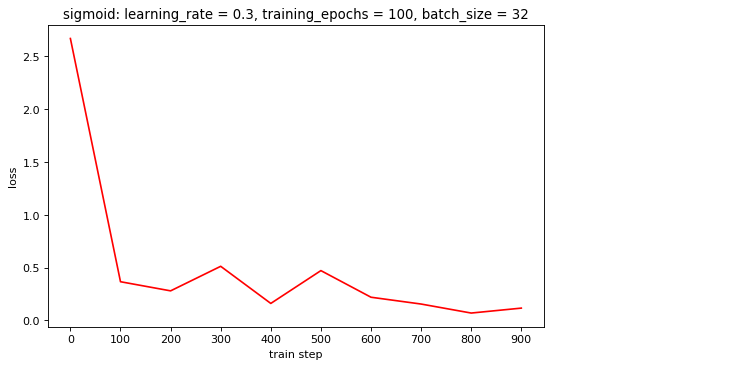

In [14]:
plt.figure(figsize=(8,5), dpi=80)
plt.xticks(np.arange(0, trainig_step, 100))
plt.plot(x_axis, loss_plot, 'r')
plt.annotate("accuracy=%s , Loss= %s" %(validate_accuracy, loss_plot[-1]), xy=(trainig_step-1, loss_plot[-1]), xytext=(-40, 10), textcoords='offset points')

plt.title('sigmoid: learning_rate = 0.3, training_epochs = 100, batch_size = 32')
plt.xlabel('train step')
plt.ylabel('loss')
plt.show()

💬 **理解：**  从上述训练可以看出，学习率的设置不太合理。因为随着训练次数的增加，loss损失的数值虽然一直在减小，但是在训练后期其数值在反复震荡，说明损失函数无法有效收敛，表明梯度下降的步长还是有问题的，究其原因还是在训练后期0.3的学习率值大了。所以，其在测试集上的正确率有点差强人意。

### 3、测试模型

    不过没关系，还是先看看具体的测试效果吧。

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./MNIST_model/model.ckpt-900

the test accuarcy is: 0.9375


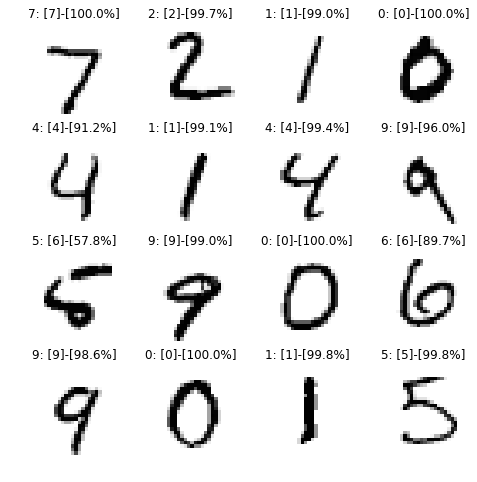

In [15]:
with tf.Session() as sess:
    
    ckpt = tf.train.get_checkpoint_state('./MNIST_model/')
    
    # 如果模型存在相应目录下，就restore恢复模型的变量
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        final_pred, acc = sess.run([pred, accuracy],
                                   feed_dict={
                                       x: mnist.test.images[:16],  # 测试集前16个数据
                                       y: mnist.test.labels[:16]
                                   })
        orders = np.argsort(final_pred)  # 新数组为排序后的原数组元素下标，换句话说，新数组最后一个值就是预测结果
        print("\nthe test accuarcy is:", acc)
        
        plt.figure(figsize=(8, 8))
        for idx in range(16):
            order = orders[idx, :][-1]  # 预测结果取数组最后一个值
            prob = final_pred[idx, :][order]  # 根据下标拿相应的预测率
            plt.subplot(4, 4, idx + 1)
            plt.axis('off')  # 不显示坐标尺寸
            plt.title('{}: [{}]-[{:.1f}%]'.format(mnist.test.labels[idx],
                                                  order, prob * 100))
            plt.imshow(mnist.test.images[idx].reshape((28, 28)), cmap='Greys', interpolation='nearest')
    else:
        pass

💬 **理解：**  这次正确率仅有94%左右，很低。嗯，怎么说呢，第三行的第一个数字5，被错误地预测成了6（其实我觉得情有可原。但总之，这个模型的效果比较差，我觉得应该是这几点造成的（小白发言）：  

    1、训练次数太少，才1000次，算下来也就1000*32=3,2000的数据参加了训练，train集都没有跑完一遍  
    2、学习率固定值不合适，损失函数无法收敛，其实可以用1/3学习率衰减嘛（1，0.3，0.1，0.03，0.01...）  
    3、隐层数的神经元少了，100个不够提取到足够的特征，换做是我就用256个Node，要么就两层Layer，16*16的那种  
    
    //以下可改不改
    
    4、权值初始化，我想用MSRA，听说它和ReLU是绝配  
    5、ReLU激活函数，我其实还好，没什么想法，不过有点想用SELU和Swish  
    6、添加正则项，不是说对于分类问题在目标函数上最好加上这个嘛，至于损失函数，交叉熵我觉得阔以  
    7、优化算法嘛，我觉得精调学习率的随机梯度下降SGD，能比得过Adam（毫无理由地相信这点呢。。  


下面是，蛮有趣的np.argsort()函数使用，我把train集前16个数据，其概率情况final_pred打印出来了。并且，后面的orders是经过这个argsort函数处理过后的结果，其最后一个值就是图片预测结果，对应回final_pred数组就是其概率值最大的那个下标。精彩！

In [16]:
final_pred

array([[8.09e-06, 1.31e-07, 5.83e-05, 7.06e-05, 3.50e-08, 4.62e-06, 3.15e-09, 1.00e+00, 3.96e-06, 1.31e-04],
       [7.82e-04, 8.59e-05, 9.97e-01, 9.24e-04, 9.48e-09, 9.41e-05, 1.13e-03, 1.03e-09, 1.90e-05, 1.03e-08],
       [9.34e-06, 9.90e-01, 2.77e-03, 1.37e-03, 3.21e-04, 1.37e-04, 1.92e-04, 4.99e-03, 2.62e-04, 1.52e-04],
       [1.00e+00, 3.60e-08, 3.94e-05, 9.29e-08, 6.38e-08, 1.58e-08, 5.50e-05, 1.18e-06, 1.44e-07, 2.47e-06],
       [2.39e-03, 4.64e-05, 7.72e-04, 1.28e-05, 9.12e-01, 1.51e-03, 2.76e-03, 9.60e-03, 4.79e-03, 6.64e-02],
       [2.95e-07, 9.91e-01, 2.40e-04, 5.01e-04, 1.39e-04, 1.89e-05, 8.49e-06, 7.43e-03, 7.55e-05, 8.72e-05],
       [1.57e-06, 1.75e-06, 2.69e-07, 9.18e-07, 9.94e-01, 9.81e-04, 2.28e-05, 3.48e-04, 1.04e-03, 3.47e-03],
       [1.01e-05, 1.44e-04, 2.88e-04, 6.53e-03, 9.41e-03, 6.47e-03, 1.69e-05, 1.70e-02, 4.54e-04, 9.60e-01],
       [4.67e-02, 2.31e-04, 3.31e-01, 4.26e-05, 1.49e-03, 3.89e-02, 5.78e-01, 9.21e-05, 2.69e-03, 6.92e-04],
       [2.35e-06, 9

In [17]:
orders

array([[6, 4, 1, 8, 5, 0, 2, 3, 9, 7],
       [7, 4, 9, 8, 1, 5, 0, 3, 6, 2],
       [0, 5, 9, 6, 8, 4, 3, 2, 7, 1],
       [5, 1, 4, 3, 8, 7, 9, 2, 6, 0],
       [3, 1, 2, 5, 0, 6, 8, 7, 9, 4],
       [0, 6, 5, 8, 9, 4, 2, 3, 7, 1],
       [2, 3, 0, 1, 6, 7, 5, 8, 9, 4],
       [0, 6, 1, 2, 8, 5, 3, 4, 7, 9],
       [3, 7, 1, 9, 4, 8, 5, 0, 2, 6],
       [6, 1, 0, 2, 3, 5, 8, 4, 7, 9],
       [3, 1, 4, 8, 9, 7, 6, 2, 5, 0],
       [3, 1, 7, 9, 4, 2, 5, 8, 0, 6],
       [6, 1, 2, 0, 8, 3, 5, 4, 7, 9],
       [3, 1, 5, 8, 4, 2, 6, 7, 9, 0],
       [0, 6, 5, 7, 4, 8, 9, 2, 3, 1],
       [9, 7, 2, 4, 0, 6, 3, 8, 1, 5]])

💬 **理解：**  显然，最后一个就是预测结果。

## 三、优化神经网络

### 1、定义优化版的神经网络模型

#### （1）计算图

模型训练：**batch_size：**128、**trainig_step：**20000、**learning_rate：**0.01倍指数衰减  

第一层：输入层、**x：**0-1（白-黑）、**y：**0/1（独热编码）  
第二层：隐层（256个节点）、**w：**方差为0.1的正态分布、**b：**常量0.1、ReLU激活  
第三层：隐层（64个节点）、**w：**方差为0.1的正态分布、**b：**常量0.1、ReLU激活  
第四层：输出层（10个节点）、**w：**方差为0.1的正态分布、**b：**常量0.1、输出未激活，但之后会用softmax激活  

In [18]:
# 获取数据集（独热编码）
mnist_new = input_data.read_data_sets("./MNIST_data/", one_hot=True)


# 定义输入和输出的占位符
x = tf.placeholder("float", [None, 784])
y = tf.placeholder("int64", [None, 10])


# 神经网络结构参数
L1_units_count = 256
L2_units_count = 64
L3_units_count = 10 


# 优化方法参数
learning_rate_base = 0.3  # 基础学习率
learning_rate_decay = 0.99  # 学习率的衰减率
regularization_rate = 0.001  # 正则化项在损失函数中的系数


# 训练参数
batch_size = 128
training_step = 20000


# 存储训练轮数，设置为不可训练
global_step = tf.Variable(0, trainable=False)


# 定义通用函数
def weight_variable(shape):
    # 截断正态分布 标准方差为0.1
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    # 设为非零避免死神经元
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)



# 隐层Layer1：256个神经元
w_1 = tf.Variable(weight_variable([784, L1_units_count]))
b_1 = tf.Variable(bias_variable([L1_units_count]))

logits_1 = tf.matmul(x, w_1) + b_1
output_1 = tf.nn.relu(logits_1)  # ReLU激活函数


# 隐层Layer2：64个神经元
w_2 = tf.Variable(weight_variable([L1_units_count, L2_units_count]))
b_2 = tf.Variable(bias_variable([L2_units_count]))

logits_2 = tf.matmul(output_1, w_2) + b_2
output_2 = tf.nn.relu(logits_2)  # ReLU激活函数


# 输出层：10个神经元
w_3 = tf.Variable(weight_variable([L2_units_count, L3_units_count]))
b_3 = tf.Variable(bias_variable([L3_units_count]))

logits_3 = tf.matmul(output_2, w_3) + b_3  
logits_new = logits_3


Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


#### （2）损失函数与优化器

    采用softmax + 交叉熵 + L2正则，与eta指数衰减 + 随机梯度下降。

In [19]:
# 设置正则化方法
regularizer = tf.contrib.layers.l2_regularizer(regularization_rate)  # 定义L2正则化损失函数
regularization = regularizer(w_1) + regularizer(w_2) + regularizer(w_3)  # 计算模型的正则化损失


# 设置指数衰减法
learning_rate = tf.train.exponential_decay(learning_rate_base, 
                                           global_step, 
                                           mnist_new.train.num_examples / batch_size,
                                           learning_rate_decay)

# softmax激活的交叉熵计算
cross_entropy_loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits_new, labels=y))

# 总损失等于交叉熵损失和正则化损失的和
loss_sum = cross_entropy_loss + regularization


# 随机梯度下降优化器
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_sum, global_step=global_step)
    

#### （3）评估性能


In [20]:
pred_new = tf.nn.softmax(logits_new)
correct_pred_new = tf.equal(tf.argmax(pred_new, 1), tf.argmax(y, 1)) 
accuracy = tf.reduce_mean(tf.cast(correct_pred_new, tf.float32))


#### （4）保存模型


In [21]:
saver = tf.train.Saver()

### 2、运行优化模型

#### （1）训练过程

In [22]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # 定义验证集与测试集
    validate_data = {x: mnist_new.validation.images, y: mnist_new.validation.labels}
    test_data = {x: mnist_new.test.images, y: mnist_new.test.labels}

    # 画图
    loss_plot=[]
    x_axis=[]
    
    # 训练模型
    for i in range(training_step):
        batch_x, batch_y = mnist_new.train.next_batch(batch_size)
        _, loss = sess.run([optimizer, loss_sum],
                           feed_dict={
                               x: batch_x,
                               y: batch_y
                           })
        
        # 每训练1000步，打印一次损失值与验证准确率
        if i % 1000 == 0:
            validate_accuracy = sess.run(accuracy, feed_dict=validate_data)
            print("after %d training steps, the loss is %g, the validation accuracy is %g" % (i, loss, validate_accuracy))
            saver.save(sess, './MNIST_model_new/model.ckpt', global_step=i)
            loss_plot.append(loss)
            x_axis.append(i)

    print("\nthe training is finish!\n")
    
    # 最终的测试准确率
    accy = sess.run(accuracy, feed_dict=test_data)
    print("the test accuarcy is:", accy)

after 0 training steps, the loss is 3.29161, the validation accuracy is 0.1532
after 1000 training steps, the loss is 0.606595, the validation accuracy is 0.9662
after 2000 training steps, the loss is 0.456373, the validation accuracy is 0.9738
after 3000 training steps, the loss is 0.274298, the validation accuracy is 0.978
after 4000 training steps, the loss is 0.205035, the validation accuracy is 0.9784
after 5000 training steps, the loss is 0.199387, the validation accuracy is 0.9826
after 6000 training steps, the loss is 0.138752, the validation accuracy is 0.9818
after 7000 training steps, the loss is 0.139159, the validation accuracy is 0.9826
after 8000 training steps, the loss is 0.124435, the validation accuracy is 0.9814
after 9000 training steps, the loss is 0.158125, the validation accuracy is 0.9816
after 10000 training steps, the loss is 0.126362, the validation accuracy is 0.9814
after 11000 training steps, the loss is 0.119063, the validation accuracy is 0.983
after 12

💬 **理解：**  正确率上98%，这么难的吗？？？？调学习率、隐层神经元什么的，我都快调懵了，What？人家一个CNN轻轻松松上98，而我这个......嗨呀

    1、修改隐层数量：起到了训练速度变慢的效果。。。
                            （不是我开玩笑，真的，两层的256*64，和一层的500，效果真的属于一个档次，我都不知道我加它两层干嘛
    2、修改神经元个数：这个效果真的是好，立竿见影的那种。果然，神经元数量多起来，训练模型学到的特征也就多了，分类准确率一下子就上升。
    3、添加正则项：没什么效果。
                            （真的！我试了试，准确率一样的高，没区别。可能我的w参数不算多，所以模型没有过拟合，故添加正则没啥效果。嗯我不知道
    4、不同的初始化：正态分布效果是好于固定值常量值啊。
    
   **我觉得吧，还是学习率、训练次数、神经元数量调节效果明显，这说明只要数据多，一切好说。**
   

#### （2）loss曲线

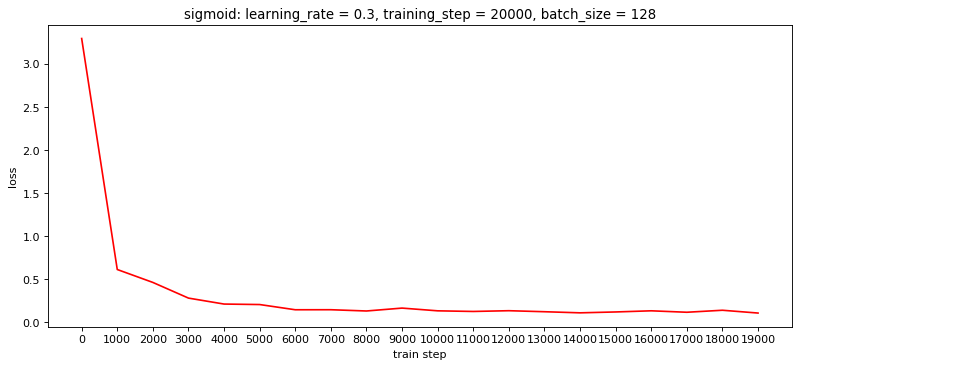

In [23]:
plt.figure(figsize=(12, 5), dpi=80)
plt.xticks(np.arange(0, training_step, 1000))
plt.plot(x_axis, loss_plot, 'r')
plt.annotate("accuracy=%s , Loss= %s" %
             (validate_accuracy, loss_plot[-1]),
             xy=(training_step-1, loss_plot[-1]), 
             xytext=(-40, 10), 
             textcoords='offset points'
            )

plt.title('sigmoid: learning_rate = 0.3, training_step = 20000, batch_size = 128')
plt.xlabel('train step')
plt.ylabel('loss')
plt.show()

💬 **理解：**  嗯，比想象中的还要麻烦呢。